In [140]:
# install models
!pip3 install lightgbm
!pip3 install xgboost
!pip3 install numpy
!pip3 install parameter-sherpa
!pip3 install GPyOpt
!pip3 install imbalanced-learn

  Using cached https://files.pythonhosted.org/packages/e6/62/08c14224a7e242df2cef7b312d2ef821c3931ec9b015ff93bb52ec8a10a3/imbalanced_learn-0.5.0-py3-none-any.whl


In [5]:
# imports
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# read in data
train_transaction_df = pd.read_csv("ieee-fraud-detection/train_transaction.csv")
test_transaction_df = pd.read_csv("ieee-fraud-detection/test_transaction.csv")
train_identity_df = pd.read_csv("ieee-fraud-detection/train_identity.csv")
test_identity_df = pd.read_csv("ieee-fraud-detection/test_identity.csv")

In [7]:
X = train_transaction_df.drop(['isFraud'],axis=1)
y = train_transaction_df['isFraud']
X_test = test_transaction_df

groups = X.columns.to_series().groupby(X.dtypes).groups
dtype_to_cols_dict = {k.name: v for k, v in groups.items()}
categorical_data = X[dtype_to_cols_dict['object']]
categorical_data.head()

,ProductCD,card4,card6,P_emaildomain,R_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,NaN,NaN,T,T,T,M2,F,T,NaN,NaN,NaN
1,W,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,M0,T,T,NaN,NaN,NaN
2,W,visa,debit,outlook.com,NaN,T,T,T,M0,F,F,F,F,F
3,W,mastercard,debit,yahoo.com,NaN,NaN,NaN,NaN,M0,T,F,NaN,NaN,NaN
4,H,mastercard,credit,gmail.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
def preprocess(X):
    X_clean = X.copy().fillna(-999)
    # TransactionDT seems to be the time in seconds
    X_clean['time'] = X['TransactionDT'] % 86400
    X_clean = X_clean.drop(['TransactionID','TransactionDT'],axis=1)
    for cat_feature in categorical_data.columns:
        X_clean[cat_feature] = X_clean[cat_feature].astype('category')
    def is_foreign_price(price):
        cents = price * 100
        return 1 if abs(cents - int(cents)) > 0.001 else 0
    for i in range(1,16):
        if i in [1,2,3,5,9]:
            continue
        X_clean['D'+str(i)+'_time'] =  X_clean['D'+str(i)] - X.TransactionDT/np.float32(24*60*60)
    X_clean['foreign_price'] = X['TransactionAmt'].map(is_foreign_price)
    return X_clean

X_clean, X_test_clean = preprocess(X), preprocess(X_test)

In [9]:
def label_and_mean_encode(X, y, X_test):
    target_mean = y.mean()
    X_encoded = X.copy()
    X_test_encoded = X_test.copy()
    for cat_feature in categorical_data.columns:
        # print(cat_feature, target_mean)
        # return y # X[cat_feature]
        X_sub = pd.concat([X[cat_feature], y], axis=1)
        cat_means = X_sub.groupby(cat_feature).mean().to_dict()['isFraud']
        def get_cat_mean(cat):
            return target_mean if cat not in cat_means else cat_means[cat]
        freqs = X[cat_feature].value_counts().to_dict()
        def get_freq(cat):
            return 0 if cat not in freqs else freqs[cat]
        X_encoded[cat_feature+'_target_encoded'] = X_encoded[cat_feature].map(get_cat_mean).replace(np.nan, target_mean)
        X_test_encoded[cat_feature+'_target_encoded'] = X_test_encoded[cat_feature].map(get_cat_mean).replace(np.nan, target_mean)
        X_encoded[cat_feature+'_freq_encoded'] = X_encoded[cat_feature].map(get_freq).replace(np.nan, 0)
        X_test_encoded[cat_feature+'_freq_encoded'] = X_test_encoded[cat_feature].map(get_freq).replace(np.nan, 0)
    return X_encoded, X_test_encoded

# X_clean, X_test_clean = mean_encode(X_clean, y, X_test_clean)
# a = label_and_mean_encode(X_clean, y, X_test_clean)


In [10]:
# X_clean[['D'+str(i) for i in range(1,16)]]

In [11]:
from sklearn.metrics import roc_auc_score
import sherpa

params = {
    'objective': 'binary',
    'max_bin': 1500,
    'max_depth': 18,
    'learning_rate': 0.01,
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'num_leaves': 80,
    'min_data_in_leaf': 75,
    'verbose': -1,
    'bagging_fraction': 0.3,
    'feature_fraction': 0.8,
    'lambda_l1': 1.4,
    'lambda_l2': 0.45,
}

parameters = [
    sherpa.Discrete(name='max_bin', range=[32, 2048]),
    sherpa.Discrete(name='max_depth', range=[4, 20]),
    sherpa.Discrete(name='min_data_in_leaf', range=[20, 400]),
    sherpa.Continuous(name='bagging_fraction', range=[0.1, 1]),
    sherpa.Continuous(name='feature_fraction', range=[0.1, 1]),
    sherpa.Continuous(name='lambda_l1', range=[0, 1]),
    sherpa.Continuous(name='lambda_l2', range=[0, 1]),
]

def run_model(X_train, y_train, X_val, y_val, params, mean_encode=False):
    X_train, X_val = label_and_mean_encode(X_train, y_train, X_val)
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    gbm = lgb.train(params,
        lgb_train,
        num_boost_round=1000,
        valid_sets=lgb_eval,
        early_stopping_rounds=15,
        verbose_eval=100,
    )
    # y_train_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration)
    y_val_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
    # train_auc = roc_auc_score(y_train, y_train_pred)
    test_auc = roc_auc_score(y_val, y_val_pred)
    print('Test auc:', roc_auc_score(y_val, y_val_pred))
    return y_val_pred, test_auc

In [131]:
algorithm = sherpa.algorithms.GPyOpt(max_num_trials=150)
study = sherpa.Study(parameters=parameters, algorithm=algorithm, lower_is_better=False)

INFO:sherpa.core:
-------------------------------------------------------
SHERPA Dashboard running. Access via
http://192.168.1.243:8880 if on a cluster or
http://localhost:8880 if running locally.
-------------------------------------------------------


 * Serving Flask app "sherpa.app.app" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


In [132]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

for trial in study:
    train_index, val_index = [a for a in tscv.split(X_clean)][-1]
    p = params.copy()
    for k, v in trial.parameters.items():
        p[k] = v
    X_train, X_val = X_clean.iloc[train_index,:], X_clean.iloc[val_index,:]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    booster = lgb.Booster(p, lgb_train)
    booster.add_valid(lgb_eval, 'validation_set')
    num_iter = 10
    for iteration in range(num_iter):
        for i in range(100):
            booster.update()
        y_train_pred = booster.predict(X_train)
        y_val_pred = booster.predict(X_val)
        train_auc = roc_auc_score(y_train, y_train_pred)
        val_auc = roc_auc_score(y_val, y_val_pred)
        print('train_auc:',train_auc,'val_auc',val_auc)
        study.add_observation(trial=trial,
                              iteration=iteration,
                              objective=val_auc,
                              context={'training_error': train_auc})
    study.finalize(trial)

train_auc: 0.8593259506859013 val_auc 0.8484154943114248
train_auc: 0.8916845981593885 val_auc 0.8718407922704091
train_auc: 0.9101006218248371 val_auc 0.8853343306051851
train_auc: 0.9185076857592526 val_auc 0.8920461946175386
train_auc: 0.9248595783250837 val_auc 0.89706341528914
train_auc: 0.9291753246151019 val_auc 0.8999532120676256
train_auc: 0.9323921108897689 val_auc 0.902181607660159
train_auc: 0.9354439986143661 val_auc 0.9041938654522272
train_auc: 0.9379311160941701 val_auc 0.9056743040581225
train_auc: 0.9399680412056208 val_auc 0.9068943983792087
train_auc: 0.8598605856447886 val_auc 0.8451412095443058


KeyboardInterrupt: 

In [ ]:
study.save('study.csv')

In [12]:
# train and test data are from different times, so for validation we should split using TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=10)
model = None
preds = []
scores = []

for train_index, val_index in [i for i in tscv.split(X_clean)]:
    print(len(train_index),len(val_index))
    X_train, X_val = X_clean.iloc[train_index,:].copy(), X_clean.iloc[val_index,:].copy()
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    pred, score = run_model(X_train, y_train, X_val, y_val, params)
    preds.append(pred)
    scores.append(score)

53690 53685
Training until validation scores don't improve for 15 rounds.
Early stopping, best iteration is:
[63]	valid_0's auc: 0.885326
Test auc: 0.8853259646488918
107375 53685
Training until validation scores don't improve for 15 rounds.
[100]	valid_0's auc: 0.884443
[200]	valid_0's auc: 0.891764
Early stopping, best iteration is:
[196]	valid_0's auc: 0.891939
Test auc: 0.8919391220020857
161060 53685
Training until validation scores don't improve for 15 rounds.
[100]	valid_0's auc: 0.885031
[200]	valid_0's auc: 0.897241
[300]	valid_0's auc: 0.909852
[400]	valid_0's auc: 0.917087
[500]	valid_0's auc: 0.920882
[600]	valid_0's auc: 0.923248
[700]	valid_0's auc: 0.92448
Early stopping, best iteration is:
[770]	valid_0's auc: 0.925167
Test auc: 0.9251668923496631
214745 53685
Training until validation scores don't improve for 15 rounds.
[100]	valid_0's auc: 0.892629
[200]	valid_0's auc: 0.898472
[300]	valid_0's auc: 0.909861
[400]	valid_0's auc: 0.916946
[500]	valid_0's auc: 0.921002
[

In [13]:
# model.save_model('model_with_time_feature_and_num_leaves_and_min_data_and_max_depth_tuning.txt')
X_train_encoded, X_test_encoded = label_and_mean_encode(X_clean, y, X_test_clean)
lgb_train = lgb.Dataset(X_train_encoded, y)
model = lgb.train(params,
    lgb_train,
    num_boost_round=1500,
    verbose_eval=100,
    valid_sets=lgb_train
)

[100]	training's auc: 0.898715
[200]	training's auc: 0.915642
[300]	training's auc: 0.930089
[400]	training's auc: 0.940585
[500]	training's auc: 0.948591
[600]	training's auc: 0.954505
[700]	training's auc: 0.95865
[800]	training's auc: 0.962063
[900]	training's auc: 0.964714
[1000]	training's auc: 0.96701
[1100]	training's auc: 0.96908
[1200]	training's auc: 0.970892
[1300]	training's auc: 0.972711
[1400]	training's auc: 0.974487
[1500]	training's auc: 0.975991


In [156]:
import seaborn as sns
def get_important_features(model, X , num = 50):
    feature_import = pd.DataFrame(sorted(zip(model.feature_importance(), X.columns)), columns = ['values', 'columns'])
    plt.figure(figsize = (12,15))
    data = feature_import.sort_values(by = 'values', ascending = False)[:num]
    sns.barplot(x = 'values', y = 'columns', data = data)
    plt.show()
    return data

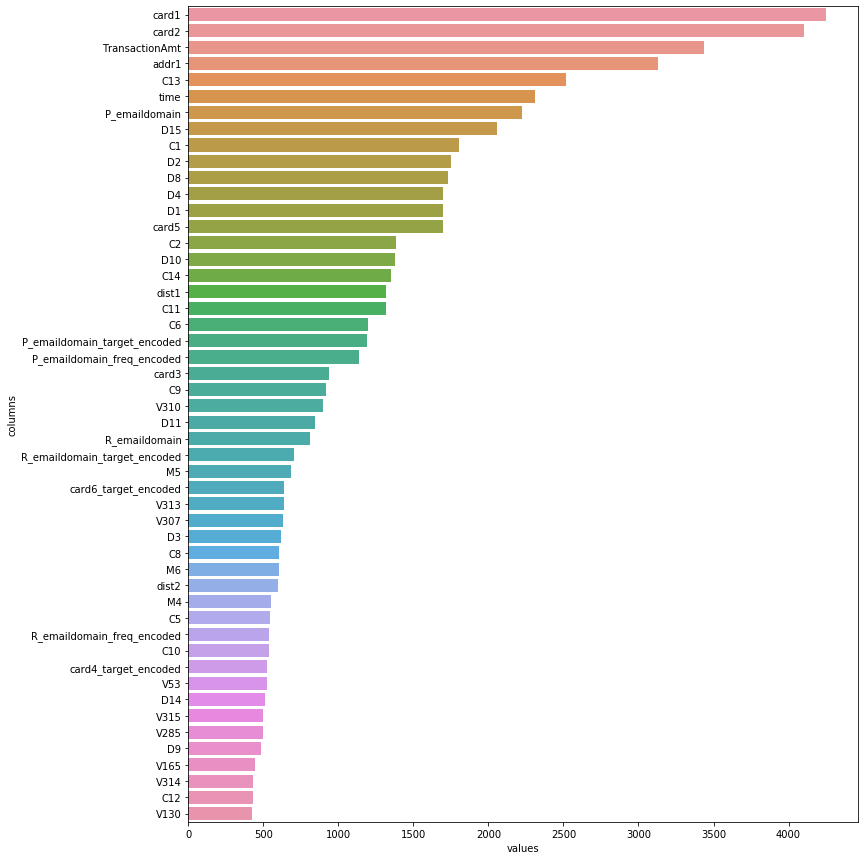

[(3437, 'TransactionAmt'),
 (339, 'ProductCD'),
 (4251, 'card1'),
 (4105, 'card2'),
 (936, 'card3'),
 (105, 'card4'),
 (1695, 'card5'),
 (111, 'card6'),
 (3129, 'addr1'),
 (141, 'addr2'),
 (1320, 'dist1'),
 (596, 'dist2'),
 (2225, 'P_emaildomain'),
 (808, 'R_emaildomain'),
 (1802, 'C1'),
 (1383, 'C2'),
 (213, 'C3'),
 (287, 'C4'),
 (542, 'C5'),
 (1198, 'C6'),
 (172, 'C7'),
 (605, 'C8'),
 (914, 'C9'),
 (535, 'C10'),
 (1320, 'C11'),
 (428, 'C12'),
 (2518, 'C13'),
 (1350, 'C14'),
 (1696, 'D1'),
 (1752, 'D2'),
 (618, 'D3'),
 (1698, 'D4'),
 (400, 'D5'),
 (290, 'D6'),
 (69, 'D7'),
 (1728, 'D8'),
 (482, 'D9'),
 (1376, 'D10'),
 (845, 'D11'),
 (242, 'D12'),
 (396, 'D13'),
 (509, 'D14'),
 (2056, 'D15'),
 (14, 'M1'),
 (116, 'M2'),
 (257, 'M3'),
 (552, 'M4'),
 (686, 'M5'),
 (602, 'M6'),
 (122, 'M7'),
 (163, 'M8'),
 (229, 'M9'),
 (1, 'V1'),
 (84, 'V2'),
 (49, 'V3'),
 (82, 'V4'),
 (116, 'V5'),
 (59, 'V6'),
 (46, 'V7'),
 (59, 'V8'),
 (12, 'V9'),
 (63, 'V10'),
 (55, 'V11'),
 (191, 'V12'),
 (161, 'V13')

In [157]:
important_features = get_important_features(model, X_train_encoded)
important_features.to_csv(path_or_buf="important_features.csv",index=False)
[i for i in zip(model.feature_importance(), model.feature_name())]

In [14]:
y_test_pred = model.predict(X_test_encoded, num_iteration=model.best_iteration)
submission_df = pd.concat([test_transaction_df.TransactionID, pd.Series(y_test_pred)],axis=1)
submission_df.columns = ["TransactionID", "isFraud"]
submission_df.to_csv(path_or_buf="submission_2.csv",index=False)

In [71]:
submission_df.head()

,TransactionID,isFraud
0,3663549,0.004490
1,3663550,0.004975
2,3663551,0.008750
3,3663552,0.002887
4,3663553,0.004666


In [146]:
submission_df.tail()
submission_df['isFraud'].describe()

count    506691.000000
mean          0.032567
std           0.116469
min           0.000112
25%           0.003156
50%           0.006655
75%           0.015039
max           0.997998
Name: isFraud, dtype: float64

In [15]:
preds_backup, scores_backup = preds, scores

In [24]:
# sum([len(a) for a in preds]) # = 536850
train_transaction_df[-536850:].TransactionID

53690     3040690
53691     3040691
53692     3040692
53693     3040693
53694     3040694
53695     3040695
53696     3040696
53697     3040697
53698     3040698
53699     3040699
53700     3040700
53701     3040701
53702     3040702
53703     3040703
53704     3040704
53705     3040705
53706     3040706
53707     3040707
53708     3040708
53709     3040709
53710     3040710
53711     3040711
53712     3040712
53713     3040713
53714     3040714
53715     3040715
53716     3040716
53717     3040717
53718     3040718
53719     3040719
           ...   
590510    3577510
590511    3577511
590512    3577512
590513    3577513
590514    3577514
590515    3577515
590516    3577516
590517    3577517
590518    3577518
590519    3577519
590520    3577520
590521    3577521
590522    3577522
590523    3577523
590524    3577524
590525    3577525
590526    3577526
590527    3577527
590528    3577528
590529    3577529
590530    3577530
590531    3577531
590532    3577532
590533    3577533
590534    

In [18]:
len(X_clean)

590540

In [111]:
for k,v in dict2.items():
    print(k,v)

d 6
c 4
a 10
b 8


In [109]:
{**dict1,**dict2}

{'a': 10, 'b': 8, 'd': 6, 'c': 4}

In [113]:
dict3 = dict2.copy()
dict3['f'] = 1
dict2

{'d': 6, 'c': 4, 'a': 10, 'b': 8, 'e': 1}

In [25]:
back_pred = []
for pred in preds:
    back_pred.extend(pred)

In [31]:
train_transaction_df[-536850:].TransactionID

53690     3040690
53691     3040691
53692     3040692
53693     3040693
53694     3040694
53695     3040695
53696     3040696
53697     3040697
53698     3040698
53699     3040699
53700     3040700
53701     3040701
53702     3040702
53703     3040703
53704     3040704
53705     3040705
53706     3040706
53707     3040707
53708     3040708
53709     3040709
53710     3040710
53711     3040711
53712     3040712
53713     3040713
53714     3040714
53715     3040715
53716     3040716
53717     3040717
53718     3040718
53719     3040719
           ...   
590510    3577510
590511    3577511
590512    3577512
590513    3577513
590514    3577514
590515    3577515
590516    3577516
590517    3577517
590518    3577518
590519    3577519
590520    3577520
590521    3577521
590522    3577522
590523    3577523
590524    3577524
590525    3577525
590526    3577526
590527    3577527
590528    3577528
590529    3577529
590530    3577530
590531    3577531
590532    3577532
590533    3577533
590534    

In [34]:
train_ensemble_df = pd.concat([train_transaction_df[-536850:].reset_index().TransactionID, pd.Series(back_pred)],axis=1)
train_ensemble_df.columns = ["TransactionID", "isFraud"]
train_ensemble_df.to_csv(path_or_buf="train_ensemble_WH.csv",index=False)

In [35]:
train_ensemble_df

,TransactionID,isFraud
0,3040690,0.022922
1,3040691,0.018480
2,3040692,0.022023
3,3040693,0.016221
4,3040694,0.016221
5,3040695,0.029661
6,3040696,0.024715
7,3040697,0.023364
8,3040698,0.031017
9,3040699,0.017979


In [33]:
len(back_pred)

536850

In [36]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train_encoded, y)
# .predict(iris.data)

ValueError: could not convert string to float: 'W'

In [ ]:
gnb.predict(X_test_encoded)